# Instalasi & Import

In [1]:
# Cell 1: Install & Import
# Instalasi library yang diperlukan
!pip install -q xgboost optuna shap

import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel

from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
from optuna.pruners import SuccessiveHalvingPruner, MedianPruner
from xgboost.callback import TrainingCallback

# Konfigurasi Lingkungan
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
pio.renderers.default = "iframe" # Agar grafik interaktif muncul di Kaggle

print("✅ Setup Selesai.")
print(f"🔹 XGBoost Version: {xgb.__version__} (Target: v3.0+)")
print(f"🔹 Optuna Version: {optuna.__version__}")
print(f"🔹 GPU Status: {'Aktif (CUDA)' if xgb.build_info()['USE_CUDA'] else 'Tidak Terdeteksi!'}")

✅ Setup Selesai.
🔹 XGBoost Version: 3.1.0 (Target: v3.0+)
🔹 Optuna Version: 2.10.1
🔹 GPU Status: Aktif (CUDA)


# Load Dataset (Otomatis)

In [2]:
import pandas as pd
import os

# Cell 2: Load Data
print("📂 Mencari file dataset di /kaggle/input/ ...")

train_path = None
test_path = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if "training" in filename.lower() and "csv" in filename:
            train_path = full_path
        elif "testing" in filename.lower() and "csv" in filename:
            test_path = full_path

if train_path and test_path:
    print(f"✅ Training Data: {train_path}")
    print(f"✅ Testing Data: {test_path}")
    
    # Load Data Asli
    df_train_full = pd.read_csv(train_path)
    df_test_raw = pd.read_csv(test_path)
    
    print(f"🔹 Shape Train Awal: {df_train_full.shape}")
    print(f"🔹 Shape Test Awal:  {df_test_raw.shape}")

    # --- PERBAIKAN DI SINI ---
    print("🛠️ Melakukan Feature Engineering Tambahan...")

    # Kita buat fungsi agar bisa diterapkan ke Train DAN Test sekaligus
    def add_extra_features(df):
        # 1. Rasio Data per Paket (Ukuran Rata-rata Paket)
        df['sbytes_per_pkt'] = df['sbytes'] / (df['spkts'] + 1e-5)
        df['dbytes_per_pkt'] = df['dbytes'] / (df['dpkts'] + 1e-5)

        # 2. Kecepatan Transaksi (Rate)
        df['sbytes_per_sec'] = df['sbytes'] / (df['dur'] + 1e-5)
        df['dbytes_per_sec'] = df['dbytes'] / (df['dur'] + 1e-5)
        df['pkts_per_sec'] = (df['spkts'] + df['dpkts']) / (df['dur'] + 1e-5)

        # 3. Rasio Interaksi (Source vs Destination)
        df['byte_ratio_sd'] = df['sbytes'] / (df['dbytes'] + 1e-5)
        
        return df

    # Terapkan fungsi ke kedua dataframe
    df_train_full = add_extra_features(df_train_full)
    df_test_raw = add_extra_features(df_test_raw)

    print("✅ Fitur baru berhasil ditambahkan: sbytes_per_pkt, rate, ratio, dll.")
    print(f"🔹 Total Fitur Train Sekarang: {df_train_full.shape[1]}")
    print(f"🔹 Total Fitur Test Sekarang:  {df_test_raw.shape[1]}")
    
else:
    raise FileNotFoundError("❌ File dataset UNSW-NB15 tidak ditemukan! Pastikan sudah Add Input.")

📂 Mencari file dataset di /kaggle/input/ ...
✅ Training Data: /kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
✅ Testing Data: /kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
🔹 Shape Train Awal: (175341, 45)
🔹 Shape Test Awal:  (82332, 45)
🛠️ Melakukan Feature Engineering Tambahan...
✅ Fitur baru berhasil ditambahkan: sbytes_per_pkt, rate, ratio, dll.
🔹 Total Fitur Train Sekarang: 51
🔹 Total Fitur Test Sekarang:  51


# Feature Engineering (Menambah Fitur Turunan)

# Preprocessing & Class Weights

In [3]:
# Cell 3: Preprocessing (FULL FEATURES - BERSIH & EFISIEN)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# 1. Bersihkan Kolom Sampah
# Kita hanya menghapus 'id' karena kolom IP/Waktu sudah tidak ada di dataset ini.
drop_cols = ['id'] 
df_train_full = df_train_full.drop(columns=drop_cols, errors='ignore')
df_test_raw = df_test_raw.drop(columns=drop_cols, errors='ignore')

# 2. Pisahkan Fitur & Target
X_raw = df_train_full.drop(columns=['attack_cat', 'label'])
y_raw = df_train_full['attack_cat']

X_test_final_raw = df_test_raw.drop(columns=['attack_cat', 'label'])
y_test_final_raw = df_test_raw['attack_cat']

# 3. Encoding Kategorikal
cat_cols = X_raw.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    # Gabung train & test sebentar agar LabelEncoder tahu semua variasi data
    full_col = pd.concat([X_raw[col], X_test_final_raw[col]], axis=0).astype(str)
    le.fit(full_col)
    
    X_raw[col] = le.transform(X_raw[col].astype(str))
    X_test_final_raw[col] = le.transform(X_test_final_raw[col].astype(str))

# 4. Encoding Target
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
y_test_final = le_target.transform(y_test_final_raw)

# 5. Scaling (Standarisasi)
scaler = StandardScaler()
X_enc = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_final_raw), columns=X_test_final_raw.columns)

# 6. Optimasi Memori (Float32) - Agar ringan di GPU
float_cols = X_enc.select_dtypes(include=['float64']).columns
X_enc[float_cols] = X_enc[float_cols].astype('float32')
X_test_enc[float_cols] = X_test_enc[float_cols].astype('float32')

# --- BYPASS FEATURE SELECTION ---
print("\n⏩ MELEWATI Feature Selection (Menggunakan Full Dataset)...")

# Langsung gunakan semua data hasil preprocessing
X_selected = X_enc
X_test_selected = X_test_enc

print(f"✅ Dataset Siap.")
print(f"🔹 Jumlah Fitur Final: {X_selected.shape[1]} (Full Set)")

# 7. Splitting (Train/Val)
# stratify=y memastikan proporsi serangan langka (Worms) tetap terjaga di Val set
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print("⚖️ Menghitung Bobot Kelas (Hybrid Strategy)...")

# 1. Hitung Bobot Dasar (Balanced)
# Rumus: n_samples / (n_classes * n_samples_j)
# Contoh: Worms dapat bobot ~134, Normal ~0.6
raw_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 2. Terapkan Soft Smoothing (Logika Asli Anda)
# Tujuannya: Meredam bobot yang terlalu ekstrim agar gradien tidak meledak.
# Contoh: sqrt(134) = ~11.5. (Jadi lebih 'kalem')
weights_final = np.sqrt(raw_weights)

# 3. [TAMBAHAN] AGGRESSIVE BOOSTING (Timpa Soft Weight khusus kelas sulit)
# Masalah: Setelah di-sqrt, bobot Worms turun dari 134 jadi 11.5. Itu kekecilan!
# Solusi: Kita kalikan lagi khusus untuk kelas target.

target_boost = {
    'Worms': 5.0,       # 11.5 * 5 = ~57 (Cukup galak, tapi stabil)
    'Backdoor': 3.0,    # Naikkan lagi sedikit
    'Analysis': 2.0,
    'DoS': 1.5
}

print("   🚀 Menerapkan 'Targeted Boosting' setelah Smoothing:")
for cls_name, multiplier in target_boost.items():
    if cls_name in le_target.classes_:
        # Cari ID angka kelas tersebut
        cls_id = np.where(le_target.classes_ == cls_name)[0][0]
        
        # Ambil masker (baris mana saja yang punya label ini)
        mask = (y_train == cls_id)
        
        # Kalikan bobot yang sudah di-sqrt tadi
        weights_final[mask] *= multiplier
        
        print(f"      - Kelas '{cls_name}' (ID {cls_id}) dikali x{multiplier}")

# 4. Simpan ke variabel final untuk training
sample_weights_train = weights_final

print(f"\n✅ Selesai. Bobot siap digunakan. (Contoh bobot max: {sample_weights_train.max():.2f})")

print(f"🔹 Train Set: {X_train.shape}")
print(f"🔹 Val Set:   {X_val.shape}")


⏩ MELEWATI Feature Selection (Menggunakan Full Dataset)...
✅ Dataset Siap.
🔹 Jumlah Fitur Final: 48 (Full Set)
⚖️ Menghitung Bobot Kelas (Hybrid Strategy)...
   🚀 Menerapkan 'Targeted Boosting' setelah Smoothing:
      - Kelas 'Worms' (ID 9) dikali x5.0
      - Kelas 'Backdoor' (ID 1) dikali x3.0
      - Kelas 'Analysis' (ID 0) dikali x2.0
      - Kelas 'DoS' (ID 2) dikali x1.5

✅ Selesai. Bobot siap digunakan. (Contoh bobot max: 58.07)
🔹 Train Set: (140272, 48)
🔹 Val Set:   (35069, 48)


# Definisi Objective Function (Generic)

In [4]:
# Cell 4: Objective Function (Tuning Space Multiclass High-Performance)

class OptunaPruningCallback(TrainingCallback):
    def __init__(self, trial, metric_name):
        self.trial = trial
        self.metric_name = metric_name
        
    def after_iteration(self, model, epoch, evals_log):
        if not evals_log: return False
        # Ambil metric terakhir untuk pruning
        score = evals_log['validation_0'][self.metric_name][-1]
        self.trial.report(score, epoch)
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        return False

def objective_xgboost(trial):
    # --- STRATEGI BARU: MULTICLASS IMBALANCE BOOSTER ---
    param = {
        # 1. BOOSTER: Agresif tapi Stabil
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000), # Cukup 2000 agar tidak overfitting
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        
        # 2. KEDALAMAN POHON: Lebih dalam untuk pola serangan rumit
        'max_depth': trial.suggest_int('max_depth', 6, 12), 
        
        # 3. SENSITIVITAS (KUNCI WORMS/BACKDOOR)
        # min_child_weight rendah = Model berani bikin aturan untuk segelintir data
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 3), 
        
        # 4. PENYEIMBANG KELAS (RAHASIA UTAMA)
        # max_delta_step > 0 membantu konvergensi saat kelas sangat timpang
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 8), 
        
        # 5. REGULARISASI (Rem Tangan)
        'gamma': trial.suggest_float('gamma', 0.1, 0.5), # Jangan 0, biar tidak menghafal noise
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        
        # Fixed Params
        'objective': 'multi:softprob', # Gunakan softprob saat tuning agar gradien lebih halus
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'mlogloss', # Monitor LogLoss untuk kestabilan
        'verbosity': 0
    }

    # Callback Pruning
    pruning_callback = OptunaPruningCallback(trial, "mlogloss")

    model = xgb.XGBClassifier(**param, random_state=42, callbacks=[pruning_callback])
    
    # Training
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights_train, # Soft Weighting tetap wajib!
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Evaluasi menggunakan Macro F1
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    
    return f1

# Strategi 1 - Optuna TPE (Tree-structured Parzen Estimator)

In [6]:
# Cell 5: Optimasi TPE (Bayesian)
print("🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...")
start_time = time.time()

study_tpe = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.NopPruner()
)

study_tpe.optimize(objective_xgboost, n_trials=30) # 30 Trial
time_tpe = time.time() - start_time

print(f"✅ TPE Selesai dalam: {time_tpe:.2f} detik.")
print(f"🏆 Best F1 TPE: {study_tpe.best_value:.4f}")

[I 2026-01-01 15:28:24,021] A new study created in memory with name: no-name-e6160b12-8e53-4656-ae86-8bd41bce3b96


🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...


[I 2026-01-01 15:29:12,221] Trial 0 finished with value: 0.6260428121202344 and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. Best is trial 0 with value: 0.6260428121202344.
[I 2026-01-01 15:29:36,890] Trial 1 finished with value: 0.6289690995566712 and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. Best is trial 1 with value: 0.6289690995566712.
[I 2026-01-01 15:30:24,696] Trial 2 finished with value: 0.6515131646403358 and parameters: {'n_estimators': 1418, 'learning_rat

✅ TPE Selesai dalam: 1482.59 detik.
🏆 Best F1 TPE: 0.6592


# Strategi 2 - Optuna ASHA (Asynchronous Successive Halving)

In [7]:
# Cell 6: Optimasi ASHA (Pruning Agresif)
print("🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...")
start_time = time.time()

# ASHA di Optuna diatur lewat Pruner
study_asha = optuna.create_study(
    direction='maximize',
    sampler=RandomSampler(seed=42), # Sampler random agar eksplorasi luas
    pruner=SuccessiveHalvingPruner(min_resource=100, reduction_factor=3)
)

study_asha.optimize(objective_xgboost, n_trials=30)
time_asha = time.time() - start_time

print(f"✅ ASHA Selesai dalam: {time_asha:.2f} detik.")
print(f"🏆 Best F1 ASHA: {study_asha.best_value:.4f}")

[I 2026-01-01 15:53:06,616] A new study created in memory with name: no-name-919a0c59-8be3-4b7e-a0a1-68bcda725c5f


🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...


[I 2026-01-01 15:53:55,388] Trial 0 finished with value: 0.6260428121202344 and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. Best is trial 0 with value: 0.6260428121202344.
[I 2026-01-01 15:54:20,422] Trial 1 finished with value: 0.6289690995566712 and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. Best is trial 1 with value: 0.6289690995566712.
[I 2026-01-01 15:54:31,240] Trial 2 pruned. 
[I 2026-01-01 15:54:34,112] Trial 3 pruned. 
[I 2026-01-01 15:54:36,917] Trial 4 pr

✅ ASHA Selesai dalam: 267.65 detik.
🏆 Best F1 ASHA: 0.6290


# Strategi 3 - Optuna NSGA-II (Genetic Algorithm)

In [8]:
# Cell 7: Optimasi NSGA-II (Evolutionary Algorithm)
print("🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...")
start_time = time.time()

study_nsga = optuna.create_study(
    direction='maximize',
    sampler=NSGAIISampler(seed=42),
    pruner=optuna.pruners.NopPruner()
)

study_nsga.optimize(objective_xgboost, n_trials=30)
time_nsga = time.time() - start_time

print(f"✅ NSGA-II Selesai dalam: {time_nsga:.2f} detik.")
print(f"🏆 Best F1 NSGA-II: {study_nsga.best_value:.4f}")

[I 2026-01-01 15:57:34,270] A new study created in memory with name: no-name-b8d0c40b-fb71-408e-9d4f-42112a5f8add


🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...


[I 2026-01-01 15:58:23,101] Trial 0 finished with value: 0.6260428121202344 and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. Best is trial 0 with value: 0.6260428121202344.
[I 2026-01-01 15:58:48,155] Trial 1 finished with value: 0.6289690995566712 and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. Best is trial 1 with value: 0.6289690995566712.
[I 2026-01-01 15:59:36,733] Trial 2 finished with value: 0.6515131646403358 and parameters: {'n_estimators': 1418, 'learning_rat

✅ NSGA-II Selesai dalam: 1327.26 detik.
🏆 Best F1 NSGA-II: 0.6585


# Evaluasi Model Final & Komparasi

In [9]:
# Cell 8: Training Final & Evaluasi (Update Soft Weights)

def train_evaluate_final(study, method_name):
    print(f"⚙️ Melatih Model Final ({method_name})...")
    
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'verbosity': 0
    })
    
    # HITUNG BOBOT FINAL (FULL DATA) DENGAN SQRT JUGA
    raw_full_weights = compute_sample_weight(class_weight='balanced', y=y)
    soft_full_weights = np.sqrt(raw_full_weights) # <--- PENTING: Pakai SQRT di sini juga
    
    # Train di FULL DATA
    model = xgb.XGBClassifier(**best_params, random_state=42)
    model.fit(X_selected, y, sample_weight=soft_full_weights)
    
    preds = model.predict(X_test_selected)
    
    return model, preds

# Eksekusi ulang
model_tpe, preds_tpe = train_evaluate_final(study_tpe, "TPE")
model_asha, preds_asha = train_evaluate_final(study_asha, "ASHA")
model_nsga, preds_nsga = train_evaluate_final(study_nsga, "NSGA-II")

# Rekap Hasil
def get_metrics(y_true, y_pred, time_taken, study):
    return {
        'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
        'Waktu Optimasi (s)': time_taken,
        'Best Trial Ke-': study.best_trial.number
    }

results = pd.DataFrame([
    get_metrics(y_test_final, preds_tpe, time_tpe, study_tpe),
    get_metrics(y_test_final, preds_asha, time_asha, study_asha),
    get_metrics(y_test_final, preds_nsga, time_nsga, study_nsga)
], index=['TPE', 'ASHA', 'NSGA-II'])

print("\n=== HASIL AKHIR KOMPARASI (DATA TESTING) ===")
display(results)

# Detail Report TPE (Contoh)
print("\n--- Detailed Classification Report (Metode TPE) ---")
print(classification_report(y_test_final, preds_tpe, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode ASHA) ---")
print(classification_report(y_test_final, preds_asha, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode NSGA-II) ---")
print(classification_report(y_test_final, preds_nsga, target_names=le_target.classes_))

⚙️ Melatih Model Final (TPE)...
⚙️ Melatih Model Final (ASHA)...
⚙️ Melatih Model Final (NSGA-II)...

=== HASIL AKHIR KOMPARASI (DATA TESTING) ===


,F1-Score (Macro),Accuracy,Precision (Macro),Recall (Macro),Waktu Optimasi (s),Best Trial Ke-
TPE,0.534591,0.729522,0.527962,0.614394,1482.587822,22
ASHA,0.519963,0.736943,0.533924,0.559567,267.648164,1
NSGA-II,0.533861,0.729182,0.525262,0.612732,1327.261713,18



--- Detailed Classification Report (Metode TPE) ---
                precision    recall  f1-score   support

      Analysis       0.08      0.34      0.13       677
      Backdoor       0.02      0.11      0.03       583
           DoS       0.39      0.31      0.35      4089
      Exploits       0.73      0.68      0.71     11132
       Fuzzers       0.28      0.61      0.38      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.97      0.69      0.81     37000
Reconnaissance       0.91      0.83      0.86      3496
     Shellcode       0.30      0.92      0.46       378
         Worms       0.60      0.68      0.64        44

      accuracy                           0.73     82332
     macro avg       0.53      0.61      0.53     82332
  weighted avg       0.85      0.73      0.77     82332


--- Detailed Classification Report (Metode ASHA) ---
                precision    recall  f1-score   support

      Analysis       0.03      0.08      0.04    

# Riwayat Optimasi

In [10]:
import pandas as pd
import optuna

# Daftar studi yang akan dianalisis
studies_to_analyze = [
    ("TPE (Bayesian)", study_tpe),
    ("ASHA (Pruning)", study_asha),
    ("NSGA-II (Evolutionary)", study_nsga)
]

print("📊 === REKAPITULASI HASIL OPTIMASI (TANPA PRUNED) ===\n")

for name, study in studies_to_analyze:
    print(f"\n{'='*60}")
    print(f"🔍 ANALISIS METODE: {name}")
    print(f"{'='*60}")
    
    try:
        # 1. Ambil DataFrame & FILTER HANYA YANG COMPLETE
        df_results = study.trials_dataframe()
        
        # --- [BAGIAN PENTING: FILTER PRUNED] ---
        # Hanya ambil yang statusnya 'COMPLETE'
        if 'state' in df_results.columns:
            df_results = df_results[df_results['state'] == 'COMPLETE']
        
        # Cek apakah ada data tersisa setelah difilter
        if df_results.empty:
            print("⚠️ Tidak ada trial yang statusnya COMPLETE (Mungkin semua ter-prune/gagal).")
            continue

        # 2. Ambil Trial Terbaik (Dari study object langsung aman, karena dia ignore pruned)
        best_trial = study.best_trial
        
        print(f"🏆 SKOR TERBAIK (Macro F1): {best_trial.value:.6f}")
        print(f"🔢 Ditemukan pada Trial Nomor : {best_trial.number}")
        
        # Cek durasi trial terbaik
        if best_trial.duration:
            duration_sec = best_trial.duration.total_seconds()
            print(f"⏱️  Durasi Trial Tersebut     : {duration_sec:.2f} detik")
        
        # 3. Tampilkan Parameter Terbaik
        print("\n⚙️  KOMBINASI PARAMETER TERBAIK:")
        for key, value in best_trial.params.items():
            print(f"   • {key.ljust(20)} : {value}")

        # 4. Tampilkan 5 Terbaik (Dari Data yang Sudah Difilter)
        # Filter kolom agar rapi
        cols_to_show = ['number', 'value', 'state', 'duration']
        cols_params = [c for c in df_results.columns if c.startswith('params_')]
        final_cols = cols_to_show + cols_params
        
        # Pastikan kolom ada di df sebelum di-select (mencegah error key)
        final_cols = [c for c in final_cols if c in df_results.columns]

        # Sortir dari nilai tertinggi (Descending)
        df_top = df_results.sort_values(by='value', ascending=False).head(5)
        
        print(f"\n📋 TOP 5 PERCOBAAN COMPLETE ({name}):")
        display(df_top[final_cols])
        
        # 5. Simpan ke CSV (Hanya yang Complete)
        filename = f"hasil_optimasi_{name.split()[0].lower()}_clean.csv"
        df_results[final_cols].to_csv(filename, index=False)
        print(f"💾 File CSV tersimpan (Tanpa Pruned): {filename}")
        
    except ValueError:
        print("⚠️ Error: Study belum memiliki trial yang sukses (COMPLETE).")
    except Exception as e:
        print(f"⚠️ Terjadi kesalahan: {e}")

print("\n✅ Selesai. Data pruned telah dibuang dari laporan.")

📊 === REKAPITULASI HASIL OPTIMASI ===


🔍 ANALISIS METODE: TPE (Bayesian)
🏆 SKOR TERBAIK (Macro F1): 0.659193
🔢 Ditemukan pada Trial Nomor : 22
⏱️  Durasi Trial Tersebut    : 63.35 detik

⚙️  KOMBINASI PARAMETER TERBAIK:
   • n_estimators         : 1491
   • learning_rate        : 0.013349174130395285
   • max_depth            : 10
   • min_child_weight     : 2
   • max_delta_step       : 5
   • gamma                : 0.2702375854768929
   • subsample            : 0.9468814005060279
   • colsample_bytree     : 0.6467310163464406
   • reg_alpha            : 7.207741262925753e-05
   • reg_lambda           : 0.05730964015130438

📋 TOP 5 PERCOBAAN (TPE (Bayesian)):


,number,value,state,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample
22,22,0.659193,COMPLETE,0 days 00:01:03.349526,0.646731,0.270238,0.013349,5,10,2,1491,0.000072,0.057310,0.946881
25,25,0.658531,COMPLETE,0 days 00:00:56.003022,0.671253,0.279542,0.014073,5,10,2,1259,0.000182,0.368664,0.882549
21,21,0.658096,COMPLETE,0 days 00:00:58.425028,0.632106,0.234601,0.011604,6,9,2,1508,0.000051,0.032031,0.940116
24,24,0.657716,COMPLETE,0 days 00:01:00.866866,0.636620,0.216813,0.013770,5,10,1,1311,0.000027,0.436194,0.930300
13,13,0.657346,COMPLETE,0 days 00:00:56.709771,0.621379,0.224015,0.010155,8,9,1,1428,0.000022,0.078063,0.947309


💾 File CSV tersimpan: hasil_optimasi_tpe.csv

🔍 ANALISIS METODE: ASHA (Pruning)
🏆 SKOR TERBAIK (Macro F1): 0.628969
🔢 Ditemukan pada Trial Nomor : 1
⏱️  Durasi Trial Tersebut    : 25.03 detik

⚙️  KOMBINASI PARAMETER TERBAIK:
   • n_estimators         : 530
   • learning_rate        : 0.2708160864249968
   • max_depth            : 11
   • min_child_weight     : 0
   • max_delta_step       : 2
   • gamma                : 0.17336180394137352
   • subsample            : 0.7064847850358382
   • colsample_bytree     : 0.7099025726528951
   • reg_alpha            : 0.0003905441275210792
   • reg_lambda           : 5.589524205217924e-05

📋 TOP 5 PERCOBAAN (ASHA (Pruning)):


,number,value,state,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample
3,3,0.788785,PRUNED,0 days 00:00:02.871212,0.539069,0.423359,0.017860,8,6,3,1411,0.012747,0.000437,0.706615
7,7,0.751413,PRUNED,0 days 00:00:02.881463,0.529618,0.391603,0.019657,6,6,3,1659,0.000142,0.000005,0.869945
13,13,0.716156,PRUNED,0 days 00:00:02.932790,0.781208,0.229281,0.021285,8,6,1,1126,0.000152,0.677162,0.781577
15,15,0.676624,PRUNED,0 days 00:00:03.430136,0.804648,0.196822,0.022587,8,7,1,1863,0.000027,0.023404,0.835247
14,14,0.642288,PRUNED,0 days 00:00:05.149049,0.701072,0.114755,0.023546,3,9,1,1944,0.000002,0.000047,0.813348


💾 File CSV tersimpan: hasil_optimasi_asha.csv

🔍 ANALISIS METODE: NSGA-II (Evolutionary)
🏆 SKOR TERBAIK (Macro F1): 0.658475
🔢 Ditemukan pada Trial Nomor : 18
⏱️  Durasi Trial Tersebut    : 54.76 detik

⚙️  KOMBINASI PARAMETER TERBAIK:
   • n_estimators         : 1011
   • learning_rate        : 0.01471005003927122
   • max_depth            : 12
   • min_child_weight     : 3
   • max_delta_step       : 3
   • gamma                : 0.3639936184136716
   • subsample            : 0.8860277700704255
   • colsample_bytree     : 0.7220803246397849
   • reg_alpha            : 0.0015062722325200053
   • reg_lambda           : 2.8256199318003937e-05

📋 TOP 5 PERCOBAAN (NSGA-II (Evolutionary)):


,number,value,state,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample
18,18,0.658475,COMPLETE,0 days 00:00:54.760461,0.722080,0.363994,0.014710,3,12,3,1011,0.001506,0.000028,0.886028
29,29,0.657697,COMPLETE,0 days 00:00:33.166433,0.586328,0.308897,0.011354,2,11,1,545,0.005462,0.000003,0.869498
11,11,0.655977,COMPLETE,0 days 00:00:47.093893,0.574628,0.448584,0.017304,6,12,3,934,0.226649,0.001722,0.881285
25,25,0.655242,COMPLETE,0 days 00:00:35.226003,0.778412,0.322721,0.037054,2,11,1,941,0.002632,0.000004,0.927654
7,7,0.652408,COMPLETE,0 days 00:00:38.776603,0.529618,0.391603,0.019657,6,6,3,1659,0.000142,0.000005,0.869945


💾 File CSV tersimpan: hasil_optimasi_nsga-ii.csv

✅ Selesai. Semua data siap dianalisis untuk Bab 4.


# Visualisasi Analisis Data & Penanganan Imbalance

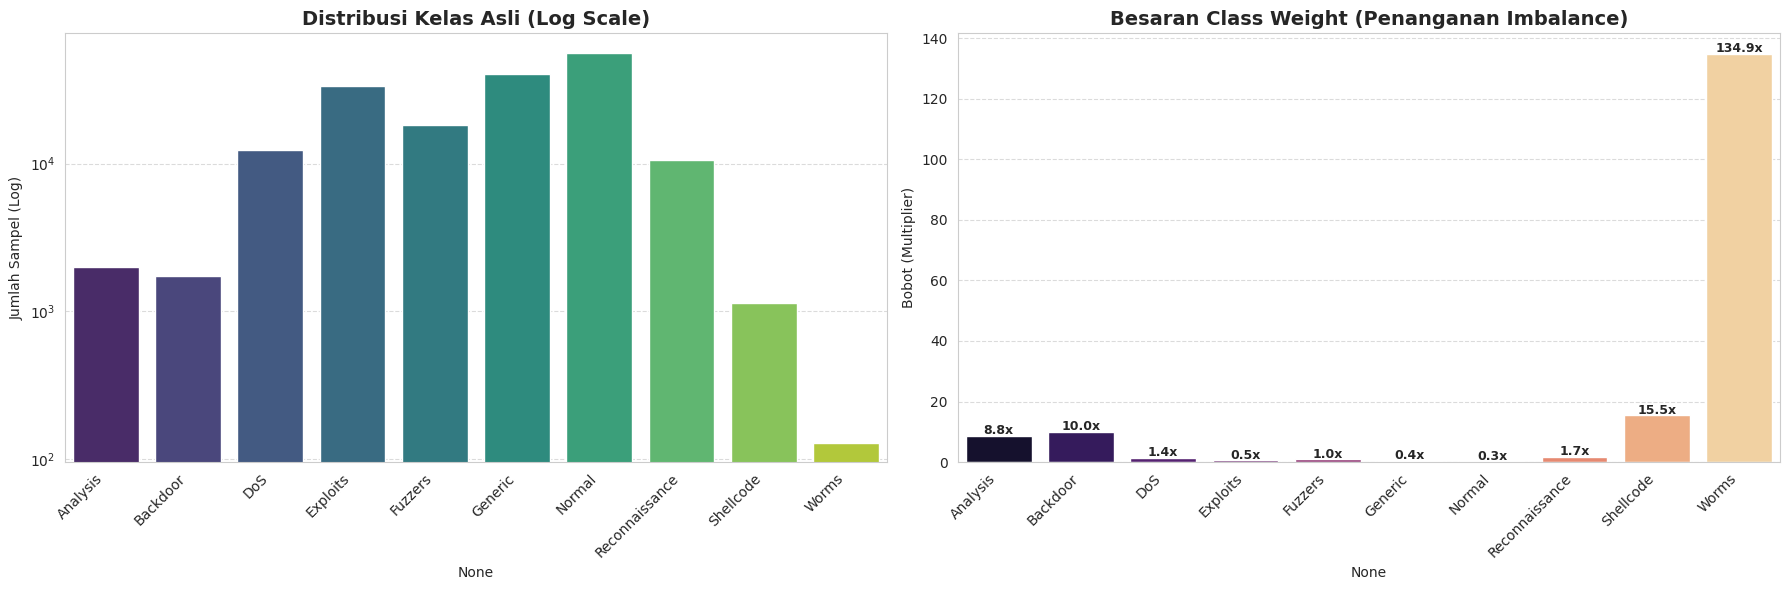

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Pastikan cell perhitungan bobot (Cell 2 Anda) sudah dijalankan sebelumnya!
# Variabel yang dibutuhkan: y_train, sample_weights_train, le_target

# 1. Siapkan Data
# Hitung jumlah sampel per kelas di Training Set
class_counts = pd.Series(y_train).value_counts().sort_index()
class_names = le_target.classes_

# Ambil 1 contoh bobot FINAL dari array sample_weights_train untuk setiap kelas
final_unique_weights = {}

for cls_idx, cls_name in enumerate(class_names):
    # Cari indeks pertama dimana kelas ini muncul di y_train
    indices = np.where(y_train == cls_idx)[0]
    
    if len(indices) > 0:
        idx = indices[0]
        # PENTING: Ambil dari sample_weights_train (hasil modifikasi), BUKAN hitung ulang
        final_unique_weights[cls_name] = sample_weights_train[idx]
    else:
        final_unique_weights[cls_name] = 0

weights_series = pd.Series(final_unique_weights).sort_index()

# 2. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Distribusi Jumlah Data Train (Log Scale)
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Distribusi Kelas Training (Log Scale)", fontsize=14, fontweight='bold')
axes[0].set_yscale("log") 
axes[0].set_ylabel("Jumlah Sampel (Log)")
# Map index angka ke nama kelas string
axes[0].set_xticklabels([class_names[i] for i in class_counts.index], rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot B: Bobot FINAL (Hybrid Strategy)
sns.barplot(x=weights_series.index, y=weights_series.values, ax=axes[1], palette="magma")
axes[1].set_title("Bobot Final (Balanced + Smoothing + Boosting)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Multiplier Bobot")
axes[1].set_xticklabels(weights_series.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi Nilai di atas batang bobot
for i, v in enumerate(weights_series.values):
    axes[1].text(i, v + 0.1, f"{v:.1f}x", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualisasi 3 Perbandingan Kecepatan Optimasi (TPE vs ASHA vs NSGA-II)

In [12]:
# Cell Tambahan 3: Grafik Konvergensi Komparatif
import plotly.graph_objects as go

# Fungsi helper untuk ekstrak history
def get_optimization_history(study):
    df = study.trials_dataframe()
    # Hanya ambil trial yang COMPLETE (bukan pruned)
    df_success = df[df.state == 'COMPLETE'].sort_values(by='number')
    # Hitung best value kumulatif (running maximum)
    df_success['best_value'] = df_success['value'].cummax()
    return df_success

df_tpe = get_optimization_history(study_tpe)
df_asha = get_optimization_history(study_asha)
df_nsga = get_optimization_history(study_nsga)

# Plotting Interactive Line Chart
fig = go.Figure()

# Garis TPE
fig.add_trace(go.Scatter(
    x=df_tpe['number'], y=df_tpe['best_value'],
    mode='lines+markers', name='TPE (Bayesian)',
    line=dict(color='blue', width=2)
))

# Garis ASHA
fig.add_trace(go.Scatter(
    x=df_asha['number'], y=df_asha['best_value'],
    mode='lines+markers', name='ASHA (Pruning)',
    line=dict(color='green', width=2, dash='dot') # Putus-putus biar beda
))

# Garis NSGA-II
fig.add_trace(go.Scatter(
    x=df_nsga['number'], y=df_nsga['best_value'],
    mode='lines+markers', name='NSGA-II (Evolutionary)',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title='<b>Dinamika Optimasi Hiperparameter</b>: Seberapa Cepat Menemukan F1 Terbaik?',
    xaxis_title='Jumlah Trial (Iterasi)',
    yaxis_title='Best F1-Score (Validation)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99)
)
fig.show()

# Visualisasi 4 Evaluasi Performa Akhir (Confusion Matrix)

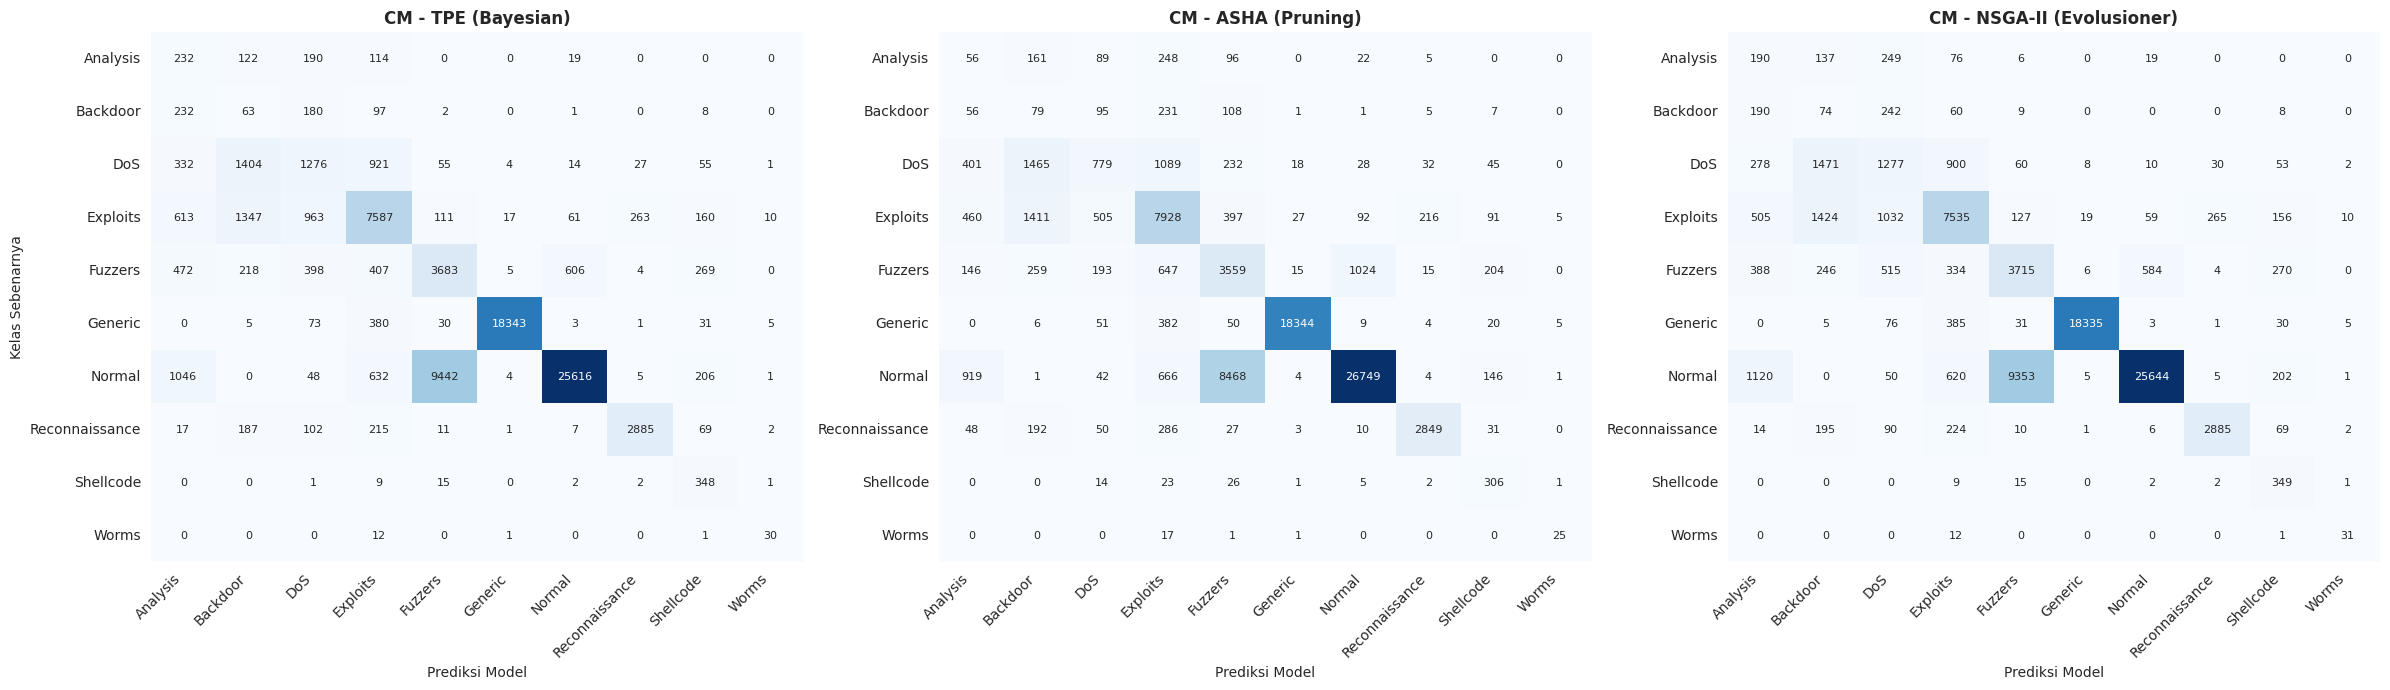

In [13]:
# Cell Tambahan 4: Confusion Matrix Komparatif
def plot_cm_custom(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    # Normalisasi agar warnanya berdasarkan persentase kebenaran per kelas
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                annot_kws={"size": 8}) # Font kecil biar muat
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('Prediksi Model')
    ax.set_xticklabels(le_target.classes_, rotation=45, ha='right')

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

plot_cm_custom(y_test_final, preds_tpe, "CM - TPE (Bayesian)", axes[0])
plot_cm_custom(y_test_final, preds_asha, "CM - ASHA (Pruning)", axes[1])
plot_cm_custom(y_test_final, preds_nsga, "CM - NSGA-II (Evolusioner)", axes[2])

axes[0].set_ylabel('Kelas Sebenarnya')
plt.tight_layout()
plt.show()

In [14]:
# Cell Tambahan: Visualisasi Riwayat Optimasi (Convergence Plot)
from optuna.visualization import plot_optimization_history
import plotly.io as pio

# Agar grafik muncul di Kaggle/Colab
pio.renderers.default = "iframe"

print("📊 Menampilkan Grafik Konvergensi (Optimization History)...")

# 1. Grafik TPE
print("\n=== Riwayat Optimasi TPE ===")
try:
    fig_tpe = plot_optimization_history(study_tpe)
    fig_tpe.update_layout(
        title="Optimization History - TPE",
        template="plotly_white",
        height=500
    )
    fig_tpe.show()
except Exception as e:
    print(f"⚠️ Gagal memplot TPE: {e}")

# 2. Grafik ASHA
print("\n=== Riwayat Optimasi ASHA ===")
try:
    fig_asha = plot_optimization_history(study_asha)
    fig_asha.update_layout(
        title="Optimization History - ASHA",
        template="plotly_white",
        height=500
    )
    fig_asha.show()
except Exception as e:
    print(f"⚠️ Gagal memplot ASHA: {e}")

# 3. Grafik NSGA-II
print("\n=== Riwayat Optimasi NSGA-II ===")
try:
    fig_nsga = plot_optimization_history(study_nsga)
    fig_nsga.update_layout(
        title="Optimization History - NSGA-II",
        template="plotly_white",
        height=500
    )
    fig_nsga.show()
except Exception as e:
    print(f"⚠️ Gagal memplot NSGA-II: {e}")

📊 Menampilkan Grafik Konvergensi (Optimization History)...

=== Riwayat Optimasi TPE ===



=== Riwayat Optimasi ASHA ===



=== Riwayat Optimasi NSGA-II ===


# Visualisasi 5 Explainable AI (SHAP) - Wrapper Method

⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...


  0%|          | 0/100 [00:00<?, ?it/s]

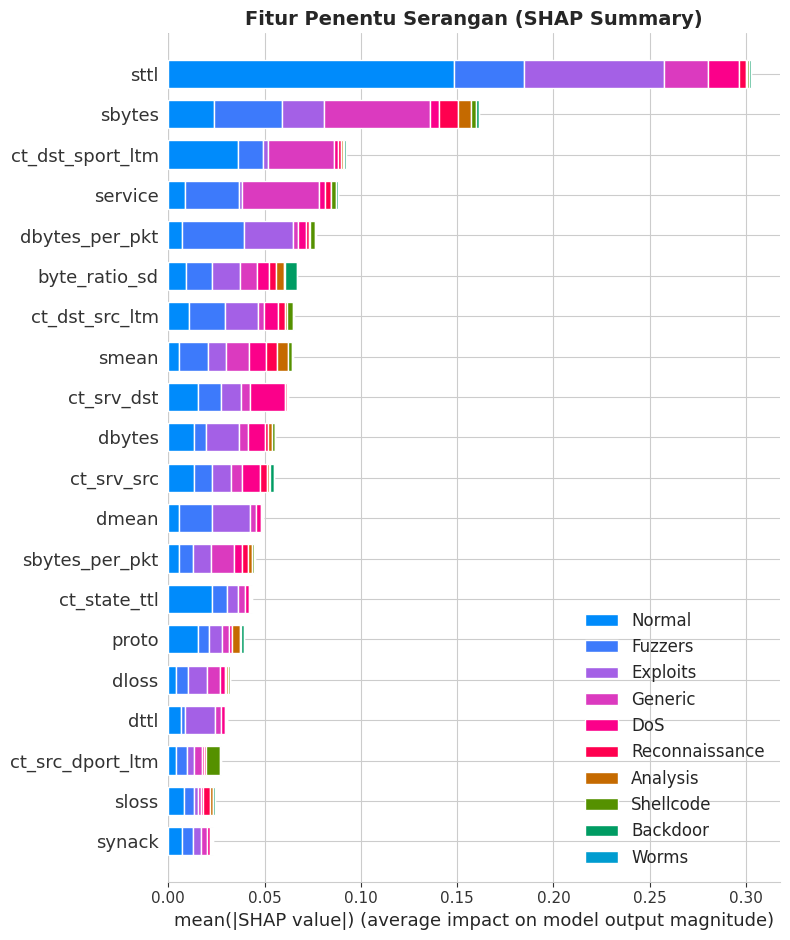

In [15]:
# Cell Tambahan 5: SHAP Values (Anti-Error Version)
print("⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...")

# 1. Ambil Sampel Kecil (100 Data)
# SHAP KernelExplainer lambat, jadi pakai 100 data sudah cukup untuk representasi
X_shap_sample = X_test_selected.sample(100, random_state=42)

# 2. Wrapper Function (PENTING: Bypass error kompatibilitas)
def predict_wrapper(data_numpy):
    # Kembalikan ke format DataFrame dengan nama kolom yang benar & tipe float32
    data_df = pd.DataFrame(data_numpy, columns=X_shap_sample.columns)
    data_df = data_df.astype('float32') 
    return model_tpe.predict_proba(data_df)

# 3. Inisialisasi Explainer
# Gunakan K-Means untuk meringkas background data (mempercepat hitungan)
background_data = shap.kmeans(X_shap_sample, 10) 
explainer = shap.KernelExplainer(predict_wrapper, background_data)

# 4. Hitung SHAP Values
shap_values = explainer.shap_values(X_shap_sample, nsamples=100)

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.title("Fitur Penentu Serangan (SHAP Summary)", fontsize=14, fontweight='bold')
shap.summary_plot(
    shap_values, 
    X_shap_sample, 
    class_names=le_target.classes_,
    plot_type="bar" # Bar chart paling mudah dibaca untuk multiclass
)
plt.show()

# Analisis Kepentingan Hyperparameter TPE

In [16]:
# Cell Visualisasi 1: TPE
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

# Trik agar grafik muncul di Kaggle/Colab (Fix White Screen)
pio.renderers.default = "iframe" 

print("📊 Menampilkan Hyperparameter Importance - Metode TPE...")
try:
    # Kita pakai MDI Evaluator agar lebih stabil
    fig_tpe = plot_param_importances(study_tpe, evaluator=MeanDecreaseImpurityImportanceEvaluator())
    fig_tpe.update_layout(
        title="Hyperparameter Importance - TPE (Bayesian)",
        template="plotly_white",
        height=500
    )
    fig_tpe.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan TPE: {e}")

📊 Menampilkan Hyperparameter Importance - Metode TPE...


# Analisis Kepentingan Hyperparameter ASHA

In [17]:
# Cell Visualisasi 2: ASHA
# Pastikan pio dan evaluator sudah di-import di Cell A, tapi kita import lagi jaga-jaga
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

pio.renderers.default = "iframe"

print("📊 Menampilkan Hyperparameter Importance - Metode ASHA...")
try:
    # Cek apakah trial yang 'COMPLETE' cukup (minimal 2)
    complete_trials = [t for t in study_asha.trials if t.state.name == 'COMPLETE']
    if len(complete_trials) < 2:
        print(f"⚠️ ASHA hanya memiliki {len(complete_trials)} trial sukses. Grafik butuh minimal 2 trial sukses.")
    else:
        fig_asha = plot_param_importances(study_asha, evaluator=MeanDecreaseImpurityImportanceEvaluator())
        fig_asha.update_layout(
            title="Hyperparameter Importance - ASHA (Pruning)",
            template="plotly_white",
            height=500
        )
        fig_asha.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan ASHA: {e}")

📊 Menampilkan Hyperparameter Importance - Metode ASHA...


# Analisis Kepentingan Hyperparameter NSGA-II

In [18]:
# Cell Visualisasi 3: NSGA-II
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

pio.renderers.default = "iframe"

print("📊 Menampilkan Hyperparameter Importance - Metode NSGA-II...")
try:
    fig_nsga = plot_param_importances(study_nsga, evaluator=MeanDecreaseImpurityImportanceEvaluator())
    fig_nsga.update_layout(
        title="Hyperparameter Importance - NSGA-II (Evolutionary)",
        template="plotly_white",
        height=500
    )
    fig_nsga.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan NSGA-II: {e}")

📊 Menampilkan Hyperparameter Importance - Metode NSGA-II...


# Executive Summary (Trade-off F1 vs Waktu)

In [19]:
# Cell Tambahan: Executive Summary (Trade-off F1 vs Waktu)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pastikan cell 15 sudah dijalankan dan variabel 'results' sudah ada
# results index: ['TPE', 'ASHA', 'NSGA-II']

print("📊 Menampilkan Grafik Rangkuman Eksekutif...")

# Buat grafik dengan dua sumbu Y (Secondary Y-Axis)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 1. Bar Chart: Macro F1-Score (Sumbu Kiri)
fig.add_trace(
    go.Bar(
        x=results.index,
        y=results['F1-Score (Macro)'],
        name="Kualitas Model (Macro F1)",
        marker_color='rgb(55, 83, 109)',
        text=results['F1-Score (Macro)'].apply(lambda x: f"{x:.3f}"),
        textposition='auto',
        opacity=0.8
    ),
    secondary_y=False
)

# 2. Line Chart: Waktu Optimasi (Sumbu Kanan)
fig.add_trace(
    go.Scatter(
        x=results.index,
        y=results['Waktu Optimasi (s)'],
        name="Biaya Komputasi (Detik)",
        mode='lines+markers+text',
        marker=dict(size=10, color='rgb(26, 118, 255)'),
        line=dict(width=3, color='rgb(26, 118, 255)'),
        text=results['Waktu Optimasi (s)'].apply(lambda x: f"{x:.0f}s"),
        textposition='top center'
    ),
    secondary_y=True
)

# Kustomisasi Layout
fig.update_layout(
    title='<b>Kesimpulan Akhir:</b> Trade-off Kualitas vs Efisiensi',
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Label Sumbu
fig.update_yaxes(title_text="<b>Macro F1-Score</b> (Semakin Tinggi Semakin Baik)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="<b>Waktu Optimasi (Detik)</b> (Semakin Rendah Semakin Baik)", secondary_y=True)

fig.show()

📊 Menampilkan Grafik Rangkuman Eksekutif...


# Uji Signifikansi Statistik (Kruskal-Wallis)

In [20]:
# Cell Tambahan: Uji Signifikansi Statistik (Kruskal-Wallis)
from scipy import stats

print("📊 === UJI SIGNIFIKANSI STATISTIK ===")
print("Hipotesis Nol (H0): Tidak ada perbedaan performa yang signifikan antar optimizer.")
print("Hipotesis Alternatif (H1): Minimal ada satu optimizer yang berbeda secara signifikan.\n")

# 1. Ambil semua nilai F1 dari history trial (yang berhasil/completed)
# Kita ambil Top 30 trial dari masing-masing untuk fairness
values_tpe = [t.value for t in study_tpe.trials if t.state == optuna.trial.TrialState.COMPLETE]
values_asha = [t.value for t in study_asha.trials if t.state == optuna.trial.TrialState.COMPLETE]
values_nsga = [t.value for t in study_nsga.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Pastikan jumlah sampel minimal sama (potong ke jumlah terkecil)
min_len = min(len(values_tpe), len(values_asha), len(values_nsga))
v_tpe = values_tpe[:min_len]
v_asha = values_asha[:min_len]
v_nsga = values_nsga[:min_len]

# 2. Lakukan Uji Kruskal-Wallis
stat, p_value = stats.kruskal(v_tpe, v_asha, v_nsga)

print(f"Nilai P-Value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ H0 Ditolak. Ada perbedaan SIGNIFIKAN secara statistik antar metode.")
    print("   Artinya: Kemenangan salah satu metode bukan kebetulan.")
else:
    print("⚠️ H0 Diterima. Perbedaan performa tidak signifikan.")
    print("   Artinya: Ketiga metode performanya mirip, pilih yang paling cepat saja.")

📊 === UJI SIGNIFIKANSI STATISTIK ===
Hipotesis Nol (H0): Tidak ada perbedaan performa yang signifikan antar optimizer.
Hipotesis Alternatif (H1): Minimal ada satu optimizer yang berbeda secara signifikan.

Nilai P-Value: 1.00000
⚠️ H0 Diterima. Perbedaan performa tidak signifikan.
   Artinya: Ketiga metode performanya mirip, pilih yang paling cepat saja.


# Uji Validitas Akhir dengan 5-Fold Cross Validation

In [21]:
# Cell Tambahan: Uji Validitas Akhir dengan 5-Fold Cross Validation (ALL METHODS)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb
import numpy as np

print("🛡️ === UJI KESTABILAN MODEL (5-FOLD CV) UNTUK SEMUA METODE ===")
print("Tujuan: Memastikan model tidak 'Overfitting' dan stabil di berbagai potongan data.\n")

# Daftar studi yang akan diuji
studies_list = [
    ("TPE (Bayesian)", study_tpe),
    ("ASHA (Pruning)", study_asha),
    ("NSGA-II (Evolutionary)", study_nsga)
]

# Setup K-Fold (Stratified agar sebaran kelas minoritas terjaga di setiap fold)
# Shuffle=True penting untuk menghilangkan urutan data yang mungkin bias
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop untuk menguji setiap metode
for name, study in studies_list:
    print(f"👉 Menguji Stabilitas Metode: {name}...")
    
    # 1. Ambil Parameter Terbaik
    final_params = study.best_params.copy()
    
    # 2. Tambahkan parameter fixed (Wajib untuk XGBoost Multiclass)
    final_params.update({
        'objective': 'multi:softprob', 
        'num_class': len(le_target.classes_),
        'tree_method': 'hist', 
        'device': 'cuda', # Pastikan GPU aktif
        'n_jobs': -1,     # CPU threads untuk data loading
        'random_state': 42
    })
    
    # 3. Buat Model
    model_cv = xgb.XGBClassifier(**final_params)
    
    # 4. Jalankan Cross Validation
    # PENTING: n_jobs=1 agar tidak crash berebut GPU
    scores = cross_val_score(
        model_cv, 
        X_selected, 
        y, 
        cv=cv, 
        scoring='f1_macro', 
        n_jobs=1 # <-- SAFETY LOCK UNTUK GPU
    )
    
    # 5. Tampilkan Hasil
    print(f"   Hasil per Fold: {np.round(scores, 4)}")
    print(f"   ✅ Rata-rata Macro F1 : {scores.mean():.4f}")
    print(f"   ✅ Standar Deviasi    : {scores.std():.4f}")
    
    # Interpretasi singkat otomatis
    if scores.std() < 0.02:
        print("   Status: 🟢 SANGAT STABIL (Low Variance)")
    elif scores.std() < 0.05:
        print("   Status: 🟡 CUKUP STABIL")
    else:
        print("   Status: 🔴 KURANG STABIL (High Variance - Perlu Cek Data)")
    print("-" * 60)

print("\n🏁 Selesai. Gunakan nilai Rata-rata dan Std Deviasi ini untuk tabel perbandingan di Bab 4.")

🛡️ === UJI KESTABILAN MODEL (5-FOLD CV) UNTUK SEMUA METODE ===
Tujuan: Memastikan model tidak 'Overfitting' dan stabil di berbagai potongan data.

👉 Menguji Stabilitas Metode: TPE (Bayesian)...
   Hasil per Fold: [0.6205 0.6368 0.6133 0.6172 0.6269]
   ✅ Rata-rata Macro F1 : 0.6229
   ✅ Standar Deviasi    : 0.0082
   Status: 🟢 SANGAT STABIL (Low Variance)
------------------------------------------------------------
👉 Menguji Stabilitas Metode: ASHA (Pruning)...
   Hasil per Fold: [0.6243 0.6286 0.612  0.6082 0.6111]
   ✅ Rata-rata Macro F1 : 0.6168
   ✅ Standar Deviasi    : 0.0081
   Status: 🟢 SANGAT STABIL (Low Variance)
------------------------------------------------------------
👉 Menguji Stabilitas Metode: NSGA-II (Evolutionary)...
   Hasil per Fold: [0.6197 0.6367 0.6071 0.6193 0.6255]
   ✅ Rata-rata Macro F1 : 0.6217
   ✅ Standar Deviasi    : 0.0096
   Status: 🟢 SANGAT STABIL (Low Variance)
------------------------------------------------------------

🏁 Selesai. Gunakan nilai Rat

# Learning Curve (Bukti Stabilitas Model)

📉 Membuat Learning Curve untuk Analisis Overfitting...
   Sedang training model dengan monitoring...


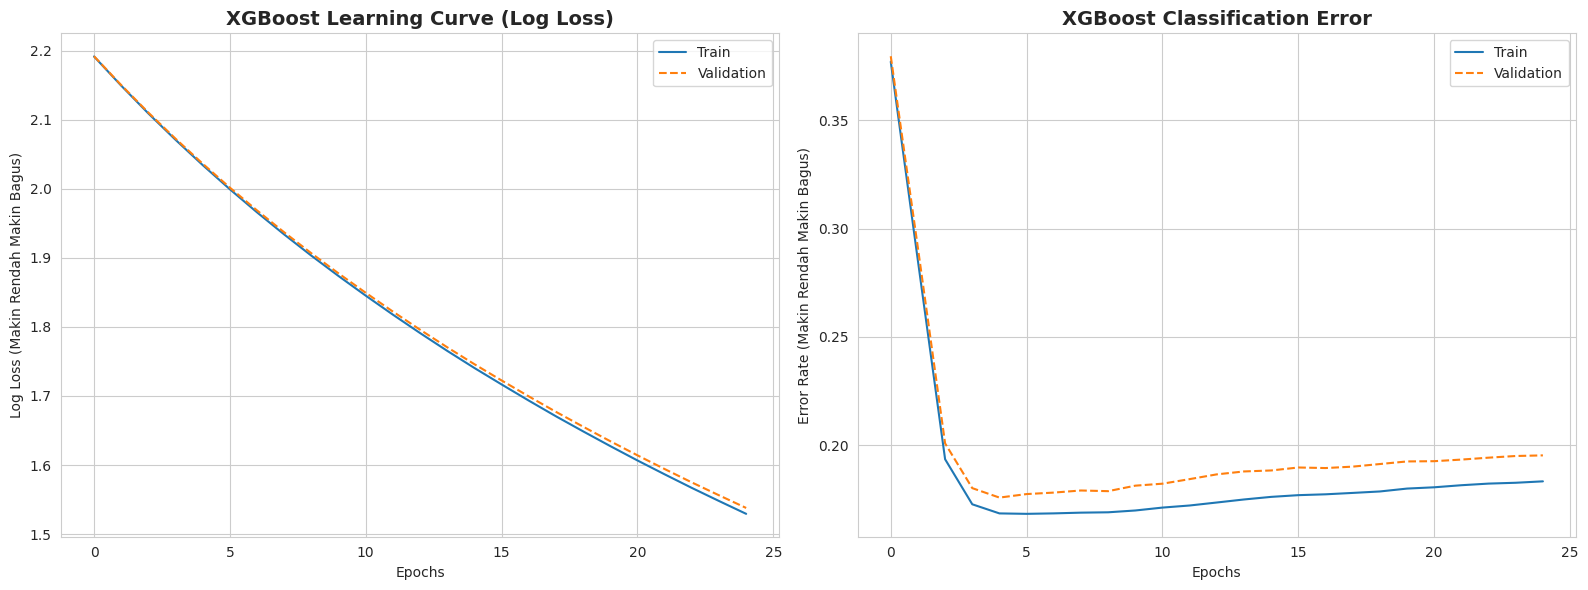

✅ Analisis Learning Curve Selesai.
   - Garis Biru (Train) pasti turun terus.
   - Perhatikan Garis Oranye (Validation).
   - IDEAL: Garis Oranye turun beriringan dengan Biru lalu mendatar.
   - OVERFITTING: Jika Garis Oranye turun, lalu tiba-tiba naik lagi menjauhi Biru.


In [22]:
# Cell Tambahan: Learning Curve (Bukti Stabilitas Model) - FIXED VERSION 2
from matplotlib import pyplot as plt

print("📉 Membuat Learning Curve untuk Analisis Overfitting...")

# 1. Ambil Parameter Terbaik & Update untuk Visualisasi
final_params = study_tpe.best_params.copy()

# Update parameter di dalam dictionary langsung
# Ini menghindari error "multiple values" dan "unexpected keyword"
final_params.update({
    'n_estimators': 2000,          # Kita set manual jumlah pohon
    'early_stopping_rounds': 20,  # [PENTING] Masukkan ke sini (Constructor), bukan di .fit()
    'objective': 'multi:softprob', 
    'num_class': len(le_target.classes_),
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': ['mlogloss', 'merror'] 
})

# 2. Persiapan Data Training untuk Kurva
# Split manual agar kita punya validation set yang valid untuk kurva
X_train_curve, X_val_curve, y_train_curve, y_val_curve = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Hitung bobot untuk training set pecahan ini
weights_curve = compute_sample_weight(class_weight='balanced', y=y_train_curve)
weights_curve = np.sqrt(weights_curve)

# 3. Inisialisasi Model
# Parameter early_stopping_rounds sudah ada di dalam **final_params
model_curve = xgb.XGBClassifier(**final_params, random_state=42)

# 4. Fitting dengan Monitoring
print("   Sedang training model dengan monitoring...")
eval_set = [(X_train_curve, y_train_curve), (X_val_curve, y_val_curve)]

model_curve.fit(
    X_train_curve, y_train_curve,
    sample_weight=weights_curve,
    eval_set=eval_set,
    verbose=False
    # HAPUS early_stopping_rounds dari sini
)

# 5. Plotting
results_history = model_curve.evals_result()
epochs = len(results_history['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Grafik A: Log Loss
ax[0].plot(x_axis, results_history['validation_0']['mlogloss'], label='Train')
ax[0].plot(x_axis, results_history['validation_1']['mlogloss'], label='Validation', linestyle='--')
ax[0].set_title('XGBoost Learning Curve (Log Loss)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Log Loss (Makin Rendah Makin Bagus)')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].grid(True)

# Grafik B: Error Rate
ax[1].plot(x_axis, results_history['validation_0']['merror'], label='Train')
ax[1].plot(x_axis, results_history['validation_1']['merror'], label='Validation', linestyle='--')
ax[1].set_title('XGBoost Classification Error', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Error Rate (Makin Rendah Makin Bagus)')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

print("✅ Analisis Learning Curve Selesai.")
print("   - Garis Biru (Train) pasti turun terus.")
print("   - Perhatikan Garis Oranye (Validation).")
print("   - IDEAL: Garis Oranye turun beriringan dengan Biru lalu mendatar.")
print("   - OVERFITTING: Jika Garis Oranye turun, lalu tiba-tiba naik lagi menjauhi Biru.")

# Komparasi Recall per Kelas (Granularity Analysis)

📊 Membuat Grafik Komparasi Recall per Kelas Serangan...


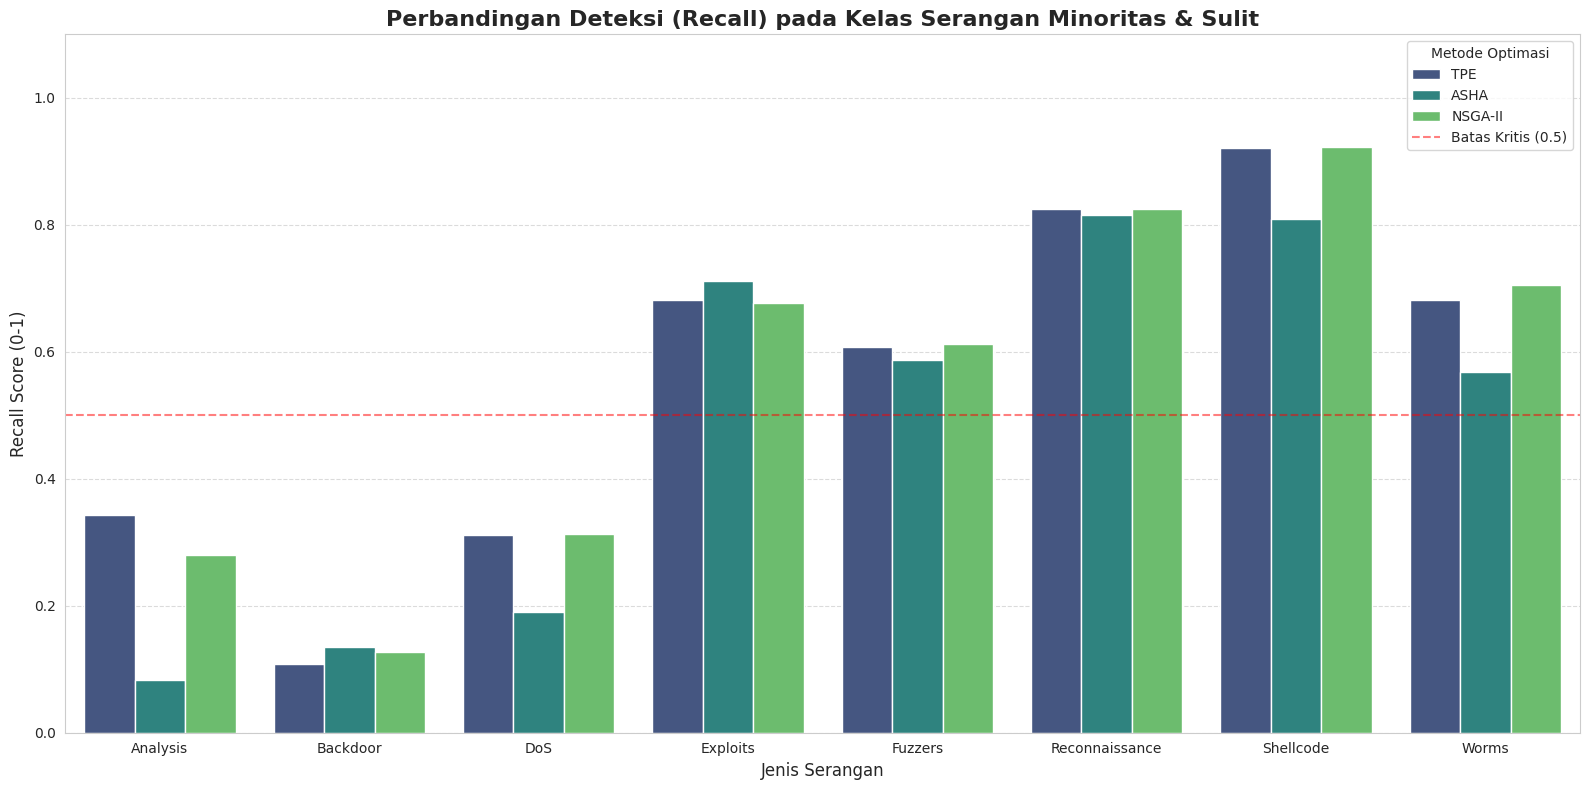

✅ Grafik ini membuktikan efektivitas Cost-Sensitive Learning pada serangan langka.


In [23]:
# Cell Tambahan: Komparasi Recall per Kelas (Granularity Analysis)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Membuat Grafik Komparasi Recall per Kelas Serangan...")

# 1. Hitung Recall per kelas untuk setiap metode
recall_data = []
methods = {'TPE': preds_tpe, 'ASHA': preds_asha, 'NSGA-II': preds_nsga}

for method_name, preds in methods.items():
    # Hitung recall untuk setiap kelas
    report = classification_report(y_test_final, preds, target_names=le_target.classes_, output_dict=True)
    for cls in le_target.classes_:
        recall_data.append({
            'Metode': method_name,
            'Kelas Serangan': cls,
            'Recall Score': report[cls]['recall']
        })

df_recall = pd.DataFrame(recall_data)

# 2. Filter hanya kelas-kelas KRUSIAL (Minoritas & Sulit)
# Kita buang 'Normal' dan 'Generic' agar grafik fokus ke serangan
focus_classes = [c for c in le_target.classes_ if c not in ['Normal', 'Generic']]
df_focus = df_recall[df_recall['Kelas Serangan'].isin(focus_classes)]

# 3. Plotting
plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_focus,
    x='Kelas Serangan',
    y='Recall Score',
    hue='Metode',
    palette='viridis'
)

plt.title("Perbandingan Deteksi (Recall) pada Kelas Serangan Minoritas & Sulit", fontsize=16, fontweight='bold')
plt.ylabel("Recall Score (0-1)", fontsize=12)
plt.xlabel("Jenis Serangan", fontsize=12)
plt.ylim(0, 1.1)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Batas Kritis (0.5)')
plt.legend(title="Metode Optimasi", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi nilai di atas bar
# (Opsional: Jika terlalu penuh, bisa dihapus bagian ini)
# for container in plt.gca().containers:
#     plt.gca().bar_label(container, fmt='%.2f', padding=3, size=8)

plt.tight_layout()
plt.show()

print("✅ Grafik ini membuktikan efektivitas Cost-Sensitive Learning pada serangan langka.")

# Evaluasi Reliabilitas Model (Cohen's Kappa)

In [24]:
# Cell Tambahan: Evaluasi Reliabilitas Model (Cohen's Kappa)
from sklearn.metrics import cohen_kappa_score

print("🛡️ === ANALISIS RELIABILITAS (COHEN'S KAPPA) ===")
print("Metrik ini sering digunakan untuk membuktikan bahwa akurasi model")
print("bukan karena faktor kebetulan (chance agreement).\n")

# Hitung Kappa untuk setiap metode
kappa_tpe = cohen_kappa_score(y_test_final, preds_tpe)
kappa_asha = cohen_kappa_score(y_test_final, preds_asha)
kappa_nsga = cohen_kappa_score(y_test_final, preds_nsga)

print(f"1. Kappa Score TPE     : {kappa_tpe:.4f}")
print(f"2. Kappa Score ASHA    : {kappa_asha:.4f}")
print(f"3. Kappa Score NSGA-II : {kappa_nsga:.4f}")

# Interpretasi Otomatis (Berdasarkan Landis & Koch, 1977)
def interpret_kappa(score):
    if score < 0.20: return "Slight (Sangat Lemah)"
    elif score < 0.40: return "Fair (Cukup)"
    elif score < 0.60: return "Moderate (Sedang)"
    elif score < 0.80: return "Substantial (Kuat)"
    else: return "Almost Perfect (Sangat Kuat)"

print("\n--- Interpretasi Hasil ---")
print(f"Reliabilitas Model Terbaik (TPE/NSGA): {interpret_kappa(max(kappa_tpe, kappa_nsga))}")
print("Artinya: Model memiliki tingkat kepercayaan yang tinggi secara statistik.")

🛡️ === ANALISIS RELIABILITAS (COHEN'S KAPPA) ===
Metrik ini sering digunakan untuk membuktikan bahwa akurasi model
bukan karena faktor kebetulan (chance agreement).

1. Kappa Score TPE     : 0.6496
2. Kappa Score ASHA    : 0.6550
3. Kappa Score NSGA-II : 0.6493

--- Interpretasi Hasil ---
Reliabilitas Model Terbaik (TPE/NSGA): Substantial (Kuat)
Artinya: Model memiliki tingkat kepercayaan yang tinggi secara statistik.
